In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.compiler import transpile
from qiskit.providers.ibmq import least_busy
import matplotlib.pyplot as plt

In [2]:
backend_to_use = "qpu" # {simulator | qpu}
qpus_to_use = ["ibmq_santiago", "ibmq_manila", "ibmq_bogota"]

if backend_to_use == "qpu":
    # Load IBMQ Account
    #token = "insert your IBMQ account token here"
    #IBMQ.save_account(token)
    if(not IBMQ.active_account()):
        IBMQ.load_account()
    provider = IBMQ.get_provider(hub="ibm-q")
    backends = provider.backends(filters=lambda x: x.name() in qpus_to_use)
    backend = least_busy(backends)
elif backend_to_use == "simulator":
    backend = Aer.get_backend('aer_simulator')
print("Using", backend.name())

Using ibmq_manila


In [3]:
# Create circuit
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)
circuit.h(qr[0])
circuit.cx(qr[0], qr[1])
circuit.measure(qr, cr)
circuit.draw()

┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0: 2/═══════════╩══╩═
                 0  1

In [4]:
# Measurement
job = execute(circuit, backend)

In [5]:
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [6]:
job.job_id()

'60ffe23be2b4f9180dc04509'

{'00': 484, '01': 23, '10': 148, '11': 369}


<BarContainer object of 4 artists>

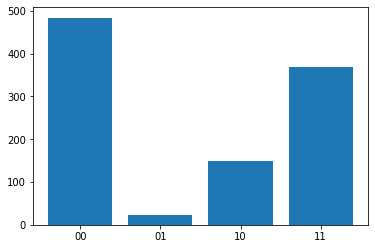

In [7]:
result = job.result()
counts =  result.get_counts()
print(counts)
plt.bar(counts.keys(), counts.values())